In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py
#import datetime

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation  

In [2]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')

In [3]:
#ROS TIME IS ALREADY WITH REFERENCE FROM EPOCH HENCE NO NEED TO SUBTRACT FROM 1970
def epoch_setup(df):
    #a=dt.datetime.utcfromtimestamp(0)
    #dtx = []
    #converting timestamp to datetime format; subtracting from epoch and converting back to seconds
    #for i in range (len(df.time)):
    #    dtx.append((dt.datetime.fromtimestamp(df.time[i])-a).total_seconds()) 
    #df.insert(1,'epoch',dtx)
    sync_time = df.time-df.time[0]
    df.insert(1,'sync_time',sync_time)
    return df

### Location of Wind Sensor & Source

31.988526614973562


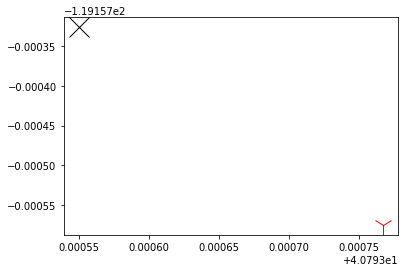

In [4]:
#distance between windstation and odor source
plt.plot([40.79355], [-119.157326], marker='x', markersize=20, color="black")
plt.plot([40.79376709443614], [-119.15757512132207], marker='1', markersize=20, color="red")

#5 inches; 0.127 meters; 12.7 cm

from geopy import distance
coords_1 = (40.79355, -119.157326)
coords_2 = (40.79376709443614, -119.15757512132207)

print (distance.geodesic(coords_1, coords_2).meters)

### Process ROS Bag Run 02 Bag 01

In [5]:
df=hp.import_csv("~/data/DesertDataOct/Run02/OctoberRun02Bag0.csv")
epoch_setup(df)


,time,sync_time,_analog_output_data,_trisonica_direction,_trisonica_header_frame_id,_trisonica_header_seq,_trisonica_header_stamp_nsecs,_trisonica_header_stamp_secs,_trisonica_humidity,_trisonica_northsouth,...,_ublox_gps_fix_position_covariance_2,_ublox_gps_fix_position_covariance_3,_ublox_gps_fix_position_covariance_4,_ublox_gps_fix_position_covariance_5,_ublox_gps_fix_position_covariance_6,_ublox_gps_fix_position_covariance_7,_ublox_gps_fix_position_covariance_8,_ublox_gps_fix_position_covariance_type,_ublox_gps_fix_status_service,_ublox_gps_fix_status_status
0,1.603221e+09,0.00,0.636031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.603221e+09,0.00,0.635718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.603221e+09,0.00,NaN,256.0,NaN,1.0,554316043.0,1.603221e+09,34.799999,1.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.603221e+09,0.01,0.634467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.603221e+09,0.01,0.636031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73433,1.603221e+09,299.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0
73434,1.603221e+09,299.73,0.593488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73435,1.603221e+09,299.73,NaN,135.0,NaN,11990.0,280133008.0,1.603221e+09,32.000000,-1.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73436,1.603221e+09,299.73,0.592237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting the GPS and WindSensor Time

In [6]:
df["trisonica_time"] = df._trisonica_header_stamp_secs + (df._trisonica_header_stamp_nsecs*1e-9)
df["gps_time"] = df._ublox_gps_fix_header_stamp_secs+(df._ublox_gps_fix_header_stamp_nsecs*1e-9)

In [7]:
df.keys()

Index(['time', 'sync_time', '_analog_output_data', '_trisonica_direction',
       '_trisonica_header_frame_id', '_trisonica_header_seq',
       '_trisonica_header_stamp_nsecs', '_trisonica_header_stamp_secs',
       '_trisonica_humidity', '_trisonica_northsouth', '_trisonica_pitch',
       '_trisonica_pressure', '_trisonica_roll', '_trisonica_speed',
       '_trisonica_temperature', '_trisonica_updown', '_trisonica_westeast',
       '_ublox_gps_fix_altitude', '_ublox_gps_fix_header_frame_id',
       '_ublox_gps_fix_header_seq', '_ublox_gps_fix_header_stamp_nsecs',
       '_ublox_gps_fix_header_stamp_secs', '_ublox_gps_fix_latitude',
       '_ublox_gps_fix_longitude', '_ublox_gps_fix_position_covariance_0',
       '_ublox_gps_fix_position_covariance_1',
       '_ublox_gps_fix_position_covariance_2',
       '_ublox_gps_fix_position_covariance_3',
       '_ublox_gps_fix_position_covariance_4',
       '_ublox_gps_fix_position_covariance_5',
       '_ublox_gps_fix_position_covariance_6',
  

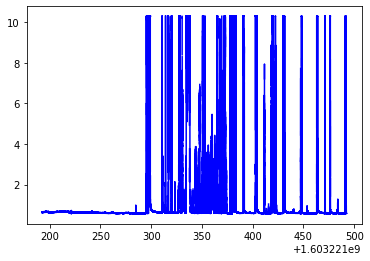

In [8]:
plt.plot(df.time, df._analog_output_data, c ='blue')

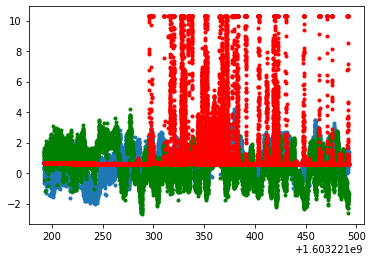

In [9]:
plt.plot(df.trisonica_time, df._trisonica_westeast, '.')
plt.plot(df.trisonica_time, df._trisonica_northsouth, '.', c='green')
plt.plot(df.time, df._analog_output_data, '.', c='red')

### Putting ODOR, WIND, GPS Together

In [10]:
df_1 = pd.DataFrame({'odor_time': df.time,'odor': df._analog_output_data,})
df_2 = pd.DataFrame({'wind_time': df.trisonica_time,'trisonica_U': df._trisonica_westeast,'trisonica_V': df._trisonica_northsouth, })
df_3 = pd.DataFrame({'gps_time': df.gps_time,'lat': df._ublox_gps_fix_latitude,'lon': df._ublox_gps_fix_longitude, })


In [11]:
dfn = pd.concat([df_1, df_2, df_3], sort=True)
combined_time = np.hstack([df.time, df.trisonica_time ,df.gps_time])

In [12]:
dfn['time'] = combined_time
dfn = dfn.sort_values(by=['time'])

In [13]:
dfn

,gps_time,lat,lon,odor,odor_time,trisonica_U,trisonica_V,wind_time,time
30,1.603221e+09,40.793749,-119.157555,NaN,NaN,NaN,NaN,NaN,1.603221e+09
79,1.603221e+09,40.793749,-119.157555,NaN,NaN,NaN,NaN,NaN,1.603221e+09
129,1.603221e+09,40.793749,-119.157555,NaN,NaN,NaN,NaN,NaN,1.603221e+09
177,1.603221e+09,40.793749,-119.157555,NaN,NaN,NaN,NaN,NaN,1.603221e+09
226,1.603221e+09,40.793749,-119.157555,NaN,NaN,NaN,NaN,NaN,1.603221e+09
...,...,...,...,...,...,...,...,...,...
73432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Interpolation

In [14]:
dt_odor = np.median(np.diff(dfn.odor_time.dropna().values))
print('dt Odor: ', dt_odor)
dt_wind = np.median(np.diff(dfn.wind_time.dropna().values))
print('dt Wind: ', dt_wind)
dt_gps = np.median(np.diff(dfn.gps_time.dropna().values))
print('dt Gps: ', dt_gps)

dt Odor:  0.0
dt Wind:  0.025002002716064453
dt Gps:  0.20000004768371582


In [15]:
first_time = np.max([dfn.odor_time.min(), dfn.wind_time.min(), dfn.gps_time.min()])
last_time = np.min([dfn.odor_time.max(), dfn.wind_time.max(), dfn.gps_time.max()])

1603221192.554316

 1603221491.1997197


In [18]:
master_time = np.arange(first_time, last_time, dt_odor)

/home/ecc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


ValueError: Maximum allowed size exceeded